# 10 Deep Learning

In [32]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as tk
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2
from keras.applications.vgg16 import VGG16
from keras.utils import load_img, img_to_array, pad_sequences
from keras.preprocessing import sequence
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model

%matplotlib inline


## 10.9.1 A Single Layer Network on the Hitters Data

In [5]:
# read the data and take a look at the data and split it into train and test 
# I copied the code from chapter (because of laziness :- )
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)


In [6]:
# the DL model is similar to other models implemeted in sklearn. 
# we first define the model, then fit the model, and finally predict the result

"""
I am listing out the hyperameters to be tuned. 
From this simple example with only one layer, we could get a sense of the number of hyperameters in NN.

Actually the number of the hyperameters gets exponentially larger as the number of layers increases.
"""
# define the model.model.add
dropout_rate = 0.4
first_layout = 50
epochs = 150
batch_size = 32
activation = 'relu'
loss = 'mean_squared_error'
optimizer = 'rmsprop'
metrics = ['mae']

model = Sequential()
model.add(Dropout(rate=dropout_rate, input_shape=(X_train.shape[1],)))
model.add(Dense(first_layout, activation=activation))
model.add(Dense(1))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
# we can use the model.summary() to see the structure of the model
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 19)                0         
                                                                 
 dense (Dense)               (None, 50)                1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# fit the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
print(model.summary())

Epoch 1/150


2022-11-14 17:50:54.448552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 1s 2ms/step - loss: 385861.5625 - mae: 442.5551
Epoch 2/150
3/3 [==============================] - 0s 1ms/step - loss: 264803.5000 - mae: 348.7518
Epoch 3/150
3/3 [==============================] - 0s 1ms/step - loss: 226903.5312 - mae: 325.5067
Epoch 4/150
3/3 [==============================] - 0s 2ms/step - loss: 231946.0625 - mae: 312.4887
Epoch 5/150
3/3 [==============================] - 0s 2ms/step - loss: 213574.6094 - mae: 292.1201
Epoch 6/150
3/3 [==============================] - 0s 2ms/step - loss: 204817.8594 - mae: 293.2062
Epoch 7/150
3/3 [==============================] - 0s 2ms/step - loss: 159430.6250 - mae: 269.6248
Epoch 8/150
3/3 [==============================] - 0s 2ms/step - loss: 214859.7500 - mae: 311.6322
Epoch 9/150
3/3 [==============================] - 0s 2ms/step - loss: 203133.1250 - mae: 293.0453
Epoch 10/150
3/3 [==============================] - 0s 4ms/step - loss: 155858.8594 - mae: 259.3270
Epoch 11/150
3/3 [===

In [8]:
# evaluate the model
# model.evaluate returns the loss value & metrics values for the model in test mode.
mse_test, mae_test = model.evaluate(X_test, y_test)
print('Test mse: %.3f, Test mae: %.3f' % (mse_test, mae_test))

6/6 [==============================] - 0s 895us/step - loss: 128249.7734 - mae: 221.7533
Test mse: 128249.773, Test mae: 221.753


## 10.9.2 A Multilayer Network on the MNIST Digit Data

In [9]:
# we could load the MNIST data set from keras.datasets
# keras.datasets also contains other well-known datasets, such as cifar10, fashion_mnist, etc.
(X_train, y_train), (X_test, y_test) = tk.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [10]:
# since the data set if for image, so each image is a 28*28 matrix.
print(X_train.shape)
print(np.max(X_train))

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(60000, 28, 28)
255
(60000,)
[0 1 2 3 4 5 6 7 8 9]


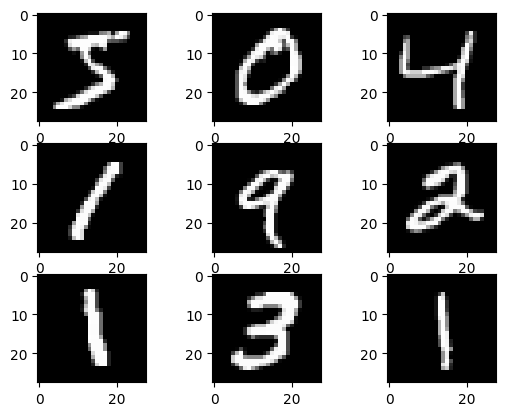

In [11]:
# let us plot some of the images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [12]:
# now let us reshape each image (i.e. matrix) to a vector
X_train = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')
""" 
We know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to 
a range of values from 0 to 1. The simplest way is to divide the value of every pixel by 255 to get the 
values in the range of 0 to 1.
"""
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
model = Sequential()
model.add(Dense(256, input_dim = 28 * 28, activation= 'relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation = 'softmax'))

In [14]:
# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3298 - accuracy: 0.9033 - val_loss: 0.1290 - val_accuracy: 0.9636
Epoch 2/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1866 - accuracy: 0.9504 - val_loss: 0.1304 - val_accuracy: 0.9659
Epoch 3/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1678 - accuracy: 0.9577 - val_loss: 0.1201 - val_accuracy: 0.9725
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1564 - accuracy: 0.9628 - val_loss: 0.1187 - val_accuracy: 0.9744
Epoch 5/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1567 - accuracy: 0.9653 - val_loss: 0.1222 - val_accuracy: 0.9752
Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1536 - accuracy: 0.9672 - val_loss: 0.1255 - val_accuracy: 0.9759
Epoch 7/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1541 - accuracy: 0.9683 - val_loss: 0.1395 - val_accuracy:

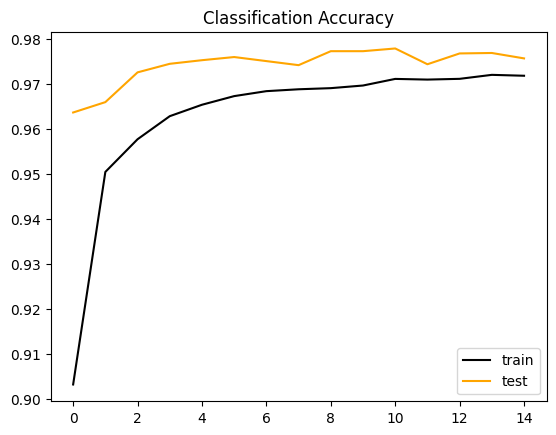

' \nOne thing to notice is the test accuracy is actually higher than the training accuracy. \nIt is kind of uncommon - if you have a good explaination on this, let me know. \n'

In [15]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()
""" 
One thing to notice is the test accuracy is actually higher than the training accuracy. 
It is kind of uncommon - if you have a good explaination on this, let me know. 
"""

## 10.9.3 Convolutional Neural Networks

In [16]:
(X_train, y_train), (X_test, y_test) = tk.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 3s 0us/step


In [17]:
# take a look at the data shape, compare to MNIST, this dataset is also image but with 
# different channels, i.e. squared image with 32×32 pixels and three color channels
print(X_train.shape)
print(np.max(X_train))

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
255
(50000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


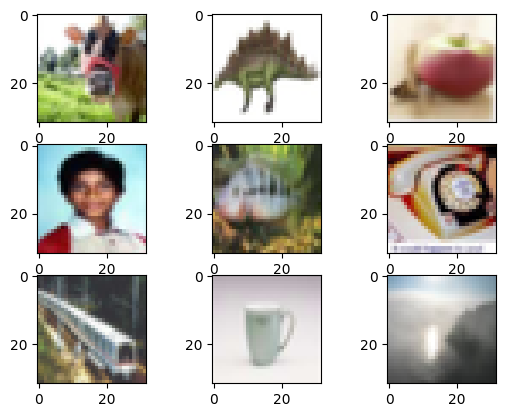

In [18]:
# show a few samples
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [19]:
# the workflow is similar to before
# we prepare the data 
# then define the model architecture 
# then fit the model 
# then exam the model performance 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
# this is a 3 block (each block contains conv layer and pooling layer) VGG architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

# then define the output classifer part of the model 
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(100, activation='softmax'))

In [21]:
# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0)
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

313/313 [==============================] - 9s 28ms/step - loss: 2.4338 - accuracy: 0.3900
Test accuracy: 0.390


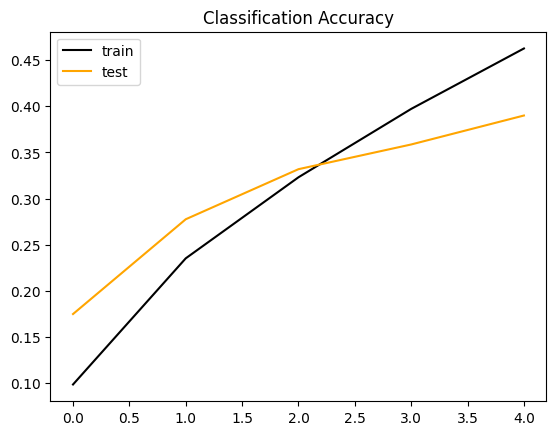

In [22]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

In [23]:
# as before, we can add in dropout 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0)
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)
""" 
From the result, we can see that adding in dropout decreases the test accuracy from 
37.6% to 34.1%. This is mainly due to the underfit of the model.

Dropout helps in the case of overfitting, to see the benefit of the dropout, we would need to 
increase epochs to a large number (~ 1000). 
"""

313/313 [==============================] - 9s 28ms/step - loss: 2.7024 - accuracy: 0.3244
Test accuracy: 0.324


' \nFrom the result, we can see that adding in dropout decreases the test accuracy from \n37.6% to 34.1%. This is mainly due to the underfit of the model.\n\nDropout helps in the case of overfitting, to see the benefit of the dropout, we would need to \nincrease epochs to a large number (~ 1000). \n'

## 10.9.4 Using Pretrained CNN Models

In [24]:
# instead of using the examples in the book, I choose a VGG model 
# to make it simple, I used VGG16. There are other pretrained models in this keras.applications class
# from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()
# fun to check the number of paramters 

553467096/553467096 [==============================] - 19s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [25]:
# load an image from file
image = load_img('../data/dog_test.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

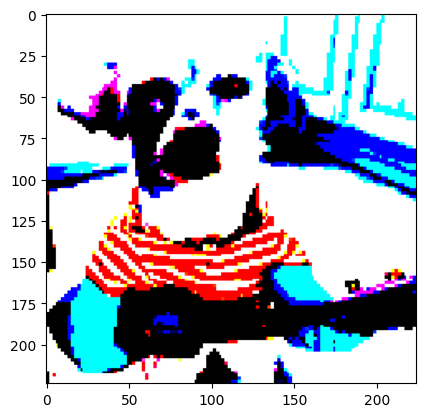

In [26]:
plt.imshow(image[0])
plt.show

In [27]:
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
print(label)

35363/35363 [==============================] - 0s 1us/step
[[('n02099712', 'Labrador_retriever', 0.21462311), ('n04597913', 'wooden_spoon', 0.06298325), ('n02085620', 'Chihuahua', 0.04350516), ('n03481172', 'hammer', 0.041385606), ('n02093256', 'Staffordshire_bullterrier', 0.039846674)]]


In [28]:
"""
there are other usage on pre-trained models. The example we showed above is to use the model directly to do the prediction. 

Other usage could be as a feature extracter: one example is below. Then we could run other simpler model on top of these features.
"""
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
features = model.predict(image)
print(features.shape)

1/1 [==============================] - 0s 303ms/step
(1, 4096)


## 10.9.5 IMDb Document Classification

In [49]:
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=10000)

In [50]:
# take a look at the data shape, compare to MNIST, this dataset is also image but with 
# different channels, i.e. squared image with 32×32 pixels and three color channels
print(X_train.shape)

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(25000,)
(25000,)
[0 1]


Review length: 
Mean 238.71 words (176.493674)


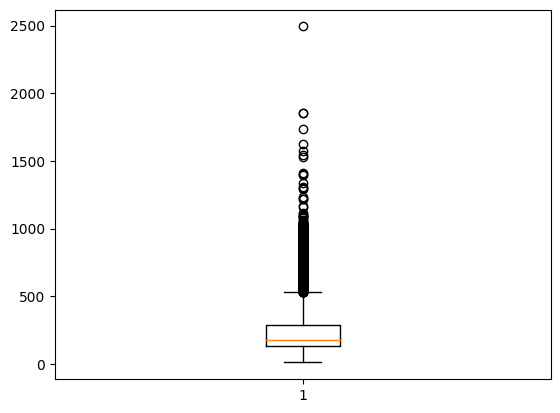

In [54]:
# summarize review length
print("Review length: ")
result = [len(x) for x in X_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [55]:
# we can cap the length of each review at 500
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [56]:
# similar to before, we can build a model. Here I skipped the OHE case, and directly went to use the 
# embedding 
model = Sequential()
model.add(Embedding(10000, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           320000    
                                                                 
 flatten_4 (Flatten)         (None, 16000)             0         
                                                                 
 dense_15 (Dense)            (None, 16)                256016    
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 576,305
Trainable params: 576,305
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
# to save compute, I only run 5 epochs
history_model = model.fit(X_train, y_train, epochs=5,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/5
49/49 [==============================] - 2s 32ms/step - loss: 0.6352 - accuracy: 0.6308 - val_loss: 0.4520 - val_accuracy: 0.8225
Epoch 2/5
49/49 [==============================] - 2s 31ms/step - loss: 0.3390 - accuracy: 0.8616 - val_loss: 0.3347 - val_accuracy: 0.8564
Epoch 3/5
49/49 [==============================] - 2s 31ms/step - loss: 0.2206 - accuracy: 0.9164 - val_loss: 0.2879 - val_accuracy: 0.8786
Epoch 4/5
49/49 [==============================] - 2s 31ms/step - loss: 0.1562 - accuracy: 0.9460 - val_loss: 0.2973 - val_accuracy: 0.8759
Epoch 5/5
782/782 [==============================] - 1s 1ms/step - loss: 0.3122 - accuracy: 0.8754
Test accuracy: 0.875


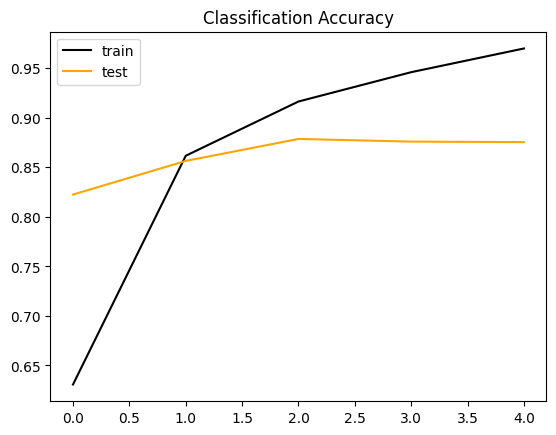

In [58]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

# similar to before, we can add dropout and other regularizations

## 10.9.6 Recurrent Neural Networks

In [60]:
# to expedite the run， I used vocabulary_size = 5000 here 
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=vocabulary_size)

# we can cap the length of each review at 500
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100)) # this is the key part of this section: the LSTM layer
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
# In theory, this RNN setup should produce better results than the CNN setup.
history_model = model.fit(X_train, y_train, epochs=10,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/10
49/49 [==============================] - 123s 2s/step - loss: 0.6660 - accuracy: 0.6740 - val_loss: 0.5077 - val_accuracy: 0.7735
Epoch 2/10
49/49 [==============================] - 114s 2s/step - loss: 0.4400 - accuracy: 0.8226 - val_loss: 0.4159 - val_accuracy: 0.8232
Epoch 3/10
49/49 [==============================] - 118s 2s/step - loss: 0.3697 - accuracy: 0.8513 - val_loss: 0.3540 - val_accuracy: 0.8535
Epoch 4/10
49/49 [==============================] - 118s 2s/step - loss: 0.3452 - accuracy: 0.8611 - val_loss: 0.3256 - val_accuracy: 0.8637
Epoch 5/10
49/49 [==============================] - 117s 2s/step - loss: 0.3008 - accuracy: 0.8786 - val_loss: 0.3836 - val_accuracy: 0.8346
Epoch 6/10
49/49 [==============================] - 117s 2s/step - loss: 0.2817 - accuracy: 0.8912 - val_loss: 0.3450 - val_accuracy: 0.8659
Epoch 7/10
49/49 [==============================] - 119s 2s/step - loss: 0.2683 - accuracy: 0.8946 - val_loss: 0.3796 - val_accuracy: 0.8343
Epoch 8/10
49

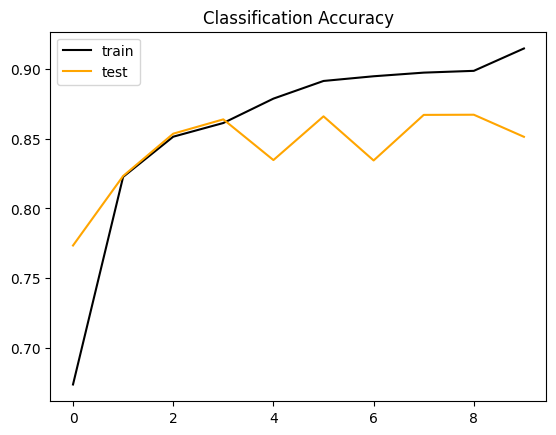

In [62]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()
